In [41]:
# import code block
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
# import requests
import csv
import time
import random
import matplotlib.pyplot as plt
from urllib.request import urlopen
import re
import numpy as np
# pip install xlsxwriter
# pip install xlwx

In [3]:
# import merged csv to DataFrame
mergedData = pd.read_csv("merged_eviction_data.csv")

In [4]:
# dropping columns not pertaining to amount of funding allocated and funding source
fundingSource = mergedData.drop(columns = ['Administering Agency','Max $ Assistance per household (total)',
       'Household Assistance Details (# of months, max per month, etc)',
       'Area Median Income Elgibility', 'Program Timeline', 'Contact info',
       'Link to application', 'Notes', 'Unnamed: 11', 'Residents 2020-10-24',
       'Count 2020-10-24', 'Residents 2020-10-31', 'Count 2020-10-31',
       'Residents 2020-11-07', 'Count 2020-11-07', 'Residents 2020-11-14',
       'Count 2020-11-14', 'Residents 2020-11-21', 'Count 2020-11-21',
       'Residents 2020-11-28', 'Count 2020-11-28', 'Residents 2020-12-05',
       'Count 2020-12-05', 'Residents 2020-12-12', 'Count 2020-12-12',
       'Residents 2020-12-19', 'Count 2020-12-19', 'Residents 2020-12-26',
       'Count 2020-12-26', 'Residents 2021-01-02', 'Count 2021-01-02',
       'Residents 2021-01-09', 'Count 2021-01-09', 'Residents 2021-01-16',
       'Count 2021-01-16', 'Residents 2021-01-23', 'Count 2021-01-23',
       'Residents 2021-01-30', 'Count 2021-01-30', 'Residents 2021-02-06',
       'Count 2021-02-06', 'Residents 2021-02-13', 'Count 2021-02-13',
       'Residents 2021-02-20', 'Count 2021-02-20', 'Residents 2021-02-27',
       'Count 2021-02-27'])

In [5]:
# cleaning funding source column for first level of standardization
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace(', and ', '/')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace(', ', '/')


fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('Trust CPA', 'Trust/CPA')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('Trust and CPA', 'Trust/CPA')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('Trust, CPA', 'Trust/CPA')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('CPA/Trust', 'Trust/CPA')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('Trust and CDBG', 'Trust/CDBG')

fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('CARES Act funds', 'CARES Act')
fundingSource['Funding Source'] = fundingSource['Funding Source'].str.replace('CARES Act ', 'CARES Act')

In [6]:
# loading this initial dataframe to a csv for error checking
fundingSource.to_csv('fundingsources.csv')

In [7]:
## fixing some of the municipalities that have multiple sources

## ARLINGTON
values = fundingSource.loc[fundingSource['Municipality'] == 'Arlington',['Municipality','Amount Allocated','Funding Source']].values.flatten().tolist()[1].split(', ')
a = dict([('Municipality','Arlington'),('CPA',values[1]),('CDBG-CV',values[0]),('Donations',values[2]),('Housing Corporation',values[3])])
arlington = pd.DataFrame.from_dict(a,orient='index').transpose()

## BROOKLINE
values = fundingSource.loc[fundingSource['Municipality'] == 'Brookline',['Municipality','Amount Allocated','Funding Source']].values.flatten().tolist()
values
b = dict([('Municipality','Brookline'),('CDBG-CV',values[2].split('and')[1]),('Town Sources', values[1]),('Housing Trust',values[2].split('and')[0]), ('Private Fundraising', values[2].split('and')[2])])
brookline = pd.DataFrame.from_dict(b,orient='index').transpose()


## BOSTON
values = fundingSource.loc[fundingSource['Municipality'] == 'Boston',['Municipality','Amount Allocated','Funding Source']].values.flatten().tolist()
bos = dict([('Municipality','Boston'),('Rental Relief Lottery', values[2].split(' - ')[0]),('Federal Stimulus Funds',values[2].split(' - ')[1])])
boston = pd.DataFrame.from_dict(bos,orient='index').transpose()

## CAMBRIDGE
values = fundingSource.loc[fundingSource['Municipality'] == 'Cambridge',['Municipality','Amount Allocated','Funding Source']].values.flatten().tolist()
cam = dict([('Municipality','Cambridge'), ('City Disaster Relief Funds/Donations', values[1])])
cambridge = pd.DataFrame.from_dict(cam,orient='index').transpose()
cambridge

,Municipality,City Disaster Relief Funds/Donations
0,Cambridge,$1.5 million is available to assist cost-burde...


In [8]:
extras = pd.merge(arlington,brookline,how='outer')
extras = pd.merge(extras,boston,how='outer')
extras = pd.merge(extras,cambridge,how='outer')
extras

,Municipality,CPA,CDBG-CV,Donations,Housing Corporation,Town Sources,Housing Trust,Private Fundraising,Rental Relief Lottery,Federal Stimulus Funds,City Disaster Relief Funds/Donations
0,Arlington,"$300,000 CPA (starting late summer/early fall","$400,000 CDBG-CV funds","$115,000 in donations through Arlington Health...","and $100,000 through Housing Corporation of Ar...",NaN,NaN,NaN,NaN,NaN,NaN
1,Brookline,NaN,"$375,000 from CDBG",NaN,NaN,$1.2 million from Town Sources plus Private Fu...,"$100,000 from Brookline Housing Trust","$725,000 from Private Fundraising",NaN,NaN,NaN
2,Boston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Round 1 of a rental relief lottery occurred on...,$5 million in federal stimulus funds.,NaN
3,Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$1.5 million is available to assist cost-burde...


In [9]:
# CARES act funding only
cares = pd.DataFrame()
cares = fundingSource[fundingSource['Funding Source'] == 'CARES Act']
cares = cares.rename(columns={'Amount Allocated':'CARES'})
cares = cares.drop(columns=['Funding Source'])

In [10]:
# trust funding only
trust = pd.DataFrame()
trust = fundingSource[fundingSource['Funding Source'] == 'Trust']
trust = trust.rename(columns={'Amount Allocated':'Trust'})
trust = trust.drop(columns=['Funding Source'])

In [11]:
# only those municipalities for which a funding source was not specified
notSpecified = pd.DataFrame()
notSpecified = fundingSource[fundingSource['Funding Source'] == 'Not specified']
notSpecified = notSpecified.rename(columns={'Amount Allocated':'Not Specified'})
notSpecified = notSpecified.drop(columns=['Funding Source'])

In [12]:
# municipalities which received funding from both trust and CPA (only)
trustCPA = pd.DataFrame()
trustCPA = fundingSource[fundingSource['Funding Source'] == 'Trust/CPA']
trustCPA = trustCPA.rename(columns={'Amount Allocated':'Trust/CPA'})
trustCPA = trustCPA.drop(columns=['Funding Source'])

In [13]:
# CPA funding only
cpa = pd.DataFrame()
cpa = fundingSource[fundingSource['Funding Source'] == 'CPA']
cpa = cpa.rename(columns={'Amount Allocated':'CPA'})
cpa = cpa.drop(columns=['Funding Source'])

In [14]:
# ESG-CV funding only
esgCv = pd.DataFrame()
esgCv = fundingSource[fundingSource['Funding Source'] == 'ESG-CV']
esgCv = esgCv.rename(columns={'Amount Allocated':'ESG-CV'})
esgCv = esgCv.drop(columns=['Funding Source'])

In [15]:
# HOME funding only
home = pd.DataFrame()
home = fundingSource[fundingSource['Funding Source']=='HOME']
home = home.rename(columns={'Amount Allocated':'HOME'})
home = home.drop(columns=['Funding Source'])

In [16]:
#CDBG/HOME-TBRA funding
cdbgHome = pd.DataFrame()
cdbgHome = fundingSource[fundingSource['Funding Source']=='CDBG/HOME-TBRA']
cdbgHome = cdbgHome.rename(columns={'Amount Allocated':'CDBG/HOME-TBRA'})
cdbgHome = cdbgHome.drop(columns=['Funding Source'])

In [17]:
# funding from city/mayoral funds
city = pd.DataFrame()
city = fundingSource[fundingSource['Funding Source']=='City funds allocated by Mayor']
city = city.rename(columns={'Amount Allocated':'City Funds Allocated by Mayor'})
city = city.drop(columns=['Funding Source'])

In [18]:
#funding from trust/CDBG-CV
trustCdbgCv = pd.DataFrame()
trustCdbgCv = fundingSource[fundingSource['Funding Source']=="Trust/CDBG-CV"]
trustCdbgCv = trustCdbgCv.rename(columns={'Amount Allocated':"Trust/CDBG-CV"})
trustCdbgCv = trustCdbgCv.drop(columns=['Funding Source'])

In [47]:
# creating base tracker for seeing all data sources broken up
sourcesTrack = pd.DataFrame(columns=['Municipality'])
sourcesTrack['Municipality'] = fundingSource['Municipality']

## Start by merging individual municipalities that needed to be cleaned more
sourcesTrack = pd.merge(sourcesTrack, extras, how='left',on='Municipality')

sourcesTrack = pd.merge(sourcesTrack, cares, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, trust, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, notSpecified, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, trustCPA, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, cpa, how='left',on=['Municipality','CPA'])
sourcesTrack = pd.merge(sourcesTrack, esgCv, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, home, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, cdbgHome, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, city, how='left',on='Municipality')
sourcesTrack = pd.merge(sourcesTrack, trustCdbgCv, how='left',on='Municipality')


sourcesTrack.to_csv('sourceTracker.csv')


In [48]:
sourcesTrack

,Municipality,CPA,CDBG-CV,Donations,Housing Corporation,Town Sources,Housing Trust,Private Fundraising,Rental Relief Lottery,Federal Stimulus Funds,City Disaster Relief Funds/Donations,CARES,Trust,Not Specified,Trust/CPA,ESG-CV,HOME,CDBG/HOME-TBRA,City Funds Allocated by Mayor,Trust/CDBG-CV
0,Acton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$55,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amesbury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not specified,NaN,NaN,NaN,NaN,NaN,NaN
2,Amherst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$250,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arlington,"$300,000 CPA (starting late summer/early fall","$400,000 CDBG-CV funds","$115,000 in donations through Arlington Health...","and $100,000 through Housing Corporation of Ar...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Barnstable County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$100,000",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Weymouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Williamstown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$20,700 Trust, $75,000 CPA",NaN,NaN,NaN,NaN,NaN
84,Yarmouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"$108,000",NaN,NaN,NaN,NaN,NaN
85,"South Berkshire Consortium, see notes*",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# sourcesTrack[''] = np.where(df['First Season'] > 1990, 1, df['First Season'])
# sourcesTrack.loc[~sourcesTrack['CPA'].isnull()] = 1  # not nan
# sourcesTrack.loc[sourcesTrack['CPA'].isnull()] = 0   # nan
# sourcesTrack['CPA'] = np.where(sourcesTrack['CPA'] != np.nan , 1, sourcesTrack['CPA'])
funding_sources = sourcesTrack
funding_sources.loc[funding_sources['CPA'].notnull(), 'CPA'] = 1
funding_sources.loc[funding_sources['CDBG-CV'].notnull(), 'CDBG-CV'] = 1
funding_sources.loc[funding_sources['Donations'].notnull(), 'Donations'] = 1
funding_sources.loc[funding_sources['Housing Corporation'].notnull(), 'Housing Corporation'] = 1
funding_sources.loc[funding_sources['Housing Corporation'].notnull(), 'Housing Corporation'] = 1
funding_sources.loc[funding_sources['Town Sources'].notnull(), 'Town Sources'] = 1
funding_sources.loc[funding_sources['Housing Trust'].notnull(), 'Housing Trust'] = 1
funding_sources.loc[funding_sources['Private Fundraising'].notnull(), 'Private Fundraising'] = 1
funding_sources.loc[funding_sources['Rental Relief Lottery'].notnull(), 'Rental Relief Lottery'] = 1
funding_sources.loc[funding_sources['Federal Stimulus Funds'].notnull(), 'Federal Stimulus Funds'] = 1
funding_sources.loc[funding_sources['City Disaster Relief Funds/Donations'].notnull(), 'City Disaster Relief Funds/Donations'] = 1
funding_sources.loc[funding_sources['CARES'].notnull(), 'CARES'] = 1
funding_sources.loc[funding_sources['Trust'].notnull(), 'Trust'] = 1
funding_sources.loc[funding_sources['Not Specified'].notnull(), 'Not Specified'] = 1
funding_sources.loc[funding_sources['Trust/CPA'].notnull(), 'Trust/CPA'] = 1
funding_sources.loc[funding_sources['ESG-CV'].notnull(), 'ESG-CV'] = 1
funding_sources.loc[funding_sources['HOME'].notnull(), 'HOME'] = 1
funding_sources.loc[funding_sources['CDBG/HOME-TBRA'].notnull(), 'CDBG/HOME-TBRA'] = 1
funding_sources.loc[funding_sources['CDBG/HOME-TBRA'].notnull(), 'CDBG/HOME-TBRA'] = 1
funding_sources.loc[funding_sources['City Funds Allocated by Mayor'].notnull(), 'City Funds Allocated by Mayor'] = 1
funding_sources.loc[funding_sources['Trust/CDBG-CV'].notnull(), 'Trust/CDBG-CV'] = 1
funding_sources = funding_sources.drop(columns=['Municipality'])
funding_sources

,CPA,CDBG-CV,Donations,Housing Corporation,Town Sources,Housing Trust,Private Fundraising,Rental Relief Lottery,Federal Stimulus Funds,City Disaster Relief Funds/Donations,CARES,Trust,Not Specified,Trust/CPA,ESG-CV,HOME,CDBG/HOME-TBRA,City Funds Allocated by Mayor,Trust/CDBG-CV
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
funding_sources.sum(axis = 0, skipna = True)

CPA                                      1.0
CDBG-CV                                  2.0
Donations                                1.0
Housing Corporation                      1.0
Town Sources                             1.0
Housing Trust                            1.0
Private Fundraising                      1.0
Rental Relief Lottery                    1.0
Federal Stimulus Funds                   1.0
City Disaster Relief Funds/Donations     1.0
CARES                                    4.0
Trust                                   29.0
Not Specified                            3.0
Trust/CPA                               27.0
ESG-CV                                  18.0
HOME                                     2.0
CDBG/HOME-TBRA                           1.0
City Funds Allocated by Mayor            1.0
Trust/CDBG-CV                            1.0
dtype: float64

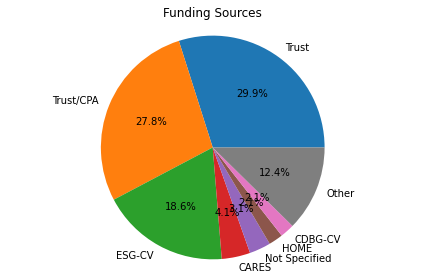

In [71]:
# my_data = [1,2,1,1,1,1,1,1,1,1,4,29,3,27,18,2,1,1,1]
my_data = [29,27,18,4,3,2,2,12]
# my_labels = 'CPA','CDBG-CV','Donations','Housing Corp.','Town Sources','Housing Trust','Private Fundraising','Rental Releif Lottery','Federal Stimulus Funds', 'City Disaster Relief Funds/Donations','CARES','Trust','Not Specified','Trust/CPA','ESG-CV','HOME','CDBG/HOME-TBRA','City Funds Allocated by mayor','Trust/CDBG-CV'
my_labels = 'Trust','Trust/CPA','ESG-CV','CARES','Not Specified','HOME','CDBG-CV','Other'
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
plt.title('Funding Sources')
plt.axis('equal')
plt.tight_layout()
plt.show()